# Causal Data Repair: Adult Dataset Example

## Load packages and the dataset

In [1]:
from etiq_core import *
import pandas as pd
import numpy as np
import itertools 
from xgboost.sklearn import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
# Load the adult data sample included in etiq
data = load_sample('adultdata')
data

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
48838,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
48839,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
48840,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


## Pre-processing the dataset 

In [3]:
# replace ? with missing values
data = data.replace('?', np.nan)
data

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
48838,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
48839,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
48840,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [4]:
# encode categorical variables

cont_vars = ['age','educational-num', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week']
cat_vars = list(set(data.columns.values) - set(cont_vars))

data_encoded = pd.DataFrame() 
encoder_dict = {}
for i in cat_vars:
    label = LabelEncoder()
    data_encoded[i]=label.fit_transform(data[i].astype(str)) 
    encoder_dict[i]=label
data_encoded.set_index(data.index, inplace=True)
df = pd.concat([data.loc[:, cont_vars], data_encoded], axis=1).copy()
data_encoded

,education,workclass,income,native-country,occupation,relationship,race,gender,marital-status
0,1,3,0,38,6,3,2,1,4
1,11,3,0,38,4,0,4,1,2
2,7,1,1,38,10,0,4,1,2
3,15,3,1,38,6,0,2,1,2
4,15,8,0,38,14,3,4,0,4
...,...,...,...,...,...,...,...,...,...
48837,7,3,0,38,12,5,4,0,2
48838,11,3,1,38,6,0,4,1,2
48839,11,3,0,38,0,4,4,0,6
48840,11,3,0,38,0,3,4,1,4


## Binarize the dataset
Reduce the domain size by binarizing all attributes.

In [5]:
D0=np.array(data_encoded)
D0_bin=np.copy(D0)

# Binarize workclass column: 1 receives an income, 0 no income
index_no_inc=np.concatenate(np.argwhere(list(data['workclass']=='Private')))
index_no_inc=np.append(index_no_inc,np.concatenate(np.argwhere(list(data['workclass']=='Self-emp-inc'))))
index_no_inc=np.append(index_no_inc,np.concatenate(np.argwhere(list(data['workclass']=='Federal-gov'))))
index_no_inc=np.append(index_no_inc,np.concatenate(np.argwhere(list(data['workclass']=='Local-gov'))))
index_no_inc=np.append(index_no_inc,np.concatenate(np.argwhere(list(data['workclass']=='State-gov'))))
index_no_wc=data_encoded.columns.get_loc('workclass')
D0_bin[:,index_no_wc]=0
D0_bin[index_no_inc,index_no_wc]=1

# Binarize race column: 1 white, 0 nonwhite
index_no_white=np.concatenate(np.argwhere(list(data['race']=='White')))
index_no_rac=data_encoded.columns.get_loc('race')
D0_bin[:,index_no_rac]=0
D0_bin[index_no_white,index_no_rac]=1

# Binarize education column: 1 university education, 0 no university education 
index_no_uni=np.concatenate(np.argwhere(list(data['education']=='Bachelors')))
index_no_uni=np.append(index_no_uni,np.concatenate(np.argwhere(list(data['education']=='Masters'))))
index_no_uni=np.append(index_no_uni,np.concatenate(np.argwhere(list(data['education']=='Prof-school'))))
index_no_uni=np.append(index_no_uni,np.concatenate(np.argwhere(list(data['education']=='Doctorate'))))
index_no_edu=data_encoded.columns.get_loc('education')
D0_bin[:,index_no_edu]=0
D0_bin[index_no_uni,index_no_edu]=1

# Binarize occupation column: 1 male dominated, 0 not male dominated 
index_no_mal=np.concatenate(np.argwhere(list(data['occupation']=='Tech-support')))
index_no_mal=np.append(index_no_mal,np.concatenate(np.argwhere(list(data['occupation']=='Exec-managerial'))))
index_no_mal=np.append(index_no_mal,np.concatenate(np.argwhere(list(data['occupation']=='Prof-specialty'))))
index_no_mal=np.append(index_no_mal,np.concatenate(np.argwhere(list(data['occupation']=='Machine-op-inspct'))))
index_no_mal=np.append(index_no_mal,np.concatenate(np.argwhere(list(data['occupation']=='Farming-fishing'))))
index_no_mal=np.append(index_no_mal,np.concatenate(np.argwhere(list(data['occupation']=='Transport-moving'))))
index_no_mal=np.append(index_no_mal,np.concatenate(np.argwhere(list(data['occupation']=='Protective-serv'))))
index_no_mal=np.append(index_no_mal,np.concatenate(np.argwhere(list(data['occupation']=='Armed-Forces'))))
index_no_occ=data_encoded.columns.get_loc('occupation')
D0_bin[:,index_no_occ]=0
D0_bin[index_no_mal,index_no_occ]=1

# Binarize relationship column: 1 married, 0 not married
index_no_mar=np.concatenate(np.argwhere(list(data['relationship']=='Wife')))
index_no_mar=np.append(index_no_mar,np.concatenate(np.argwhere(list(data['relationship']=='Husband'))))
index_no_rel=data_encoded.columns.get_loc('relationship')
D0_bin[:,index_no_rel]=0
D0_bin[index_no_mar,index_no_rel]=1

# Binarize marital status column: 1 married, 0 not married
index_no_mar2=np.concatenate(np.argwhere(list(data['marital-status']=='Married-civ-spouse')))
index_no_mar2=np.append(index_no_mar2,np.concatenate(np.argwhere(list(data['marital-status']=='Married-spouse-absent'))))
index_no_mar2=np.append(index_no_mar2,np.concatenate(np.argwhere(list(data['marital-status']=='Married-AF-spouse'))))
index_no_ms=data_encoded.columns.get_loc('marital-status')
D0_bin[:,index_no_ms]=0
D0_bin[index_no_mar2,index_no_ms]=1

# Binarize native-country column: 1 United-States, 0 outside United-States
index_no_usa=np.concatenate(np.argwhere(list(data['native-country']=='United-States')))
index_no_nc=data_encoded.columns.get_loc('native-country')
D0_bin[:,index_no_nc]=0
D0_bin[index_no_usa,index_no_nc]=1


## Generate the causal graph using the PC method
The [Causal Discovery Toolbox](https://fentechsolutions.github.io/CausalDiscoveryToolbox/html/index.html) is used to plot the causal graph with the PC method, which uses a Gaussian test for conditional independence called gaussCItest from the pcalg package. For example, it determines if X is independent of Y, conditional on Z by computing the partial correlation of X and Y given Z, and testing if it is close to zero.

In [6]:
## Import packages for the Casual Discovery Toolbox

import cdt
import math
import networkx as nx
import matplotlib.pyplot as plt
from cdt.causality.graph import PC, GES

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


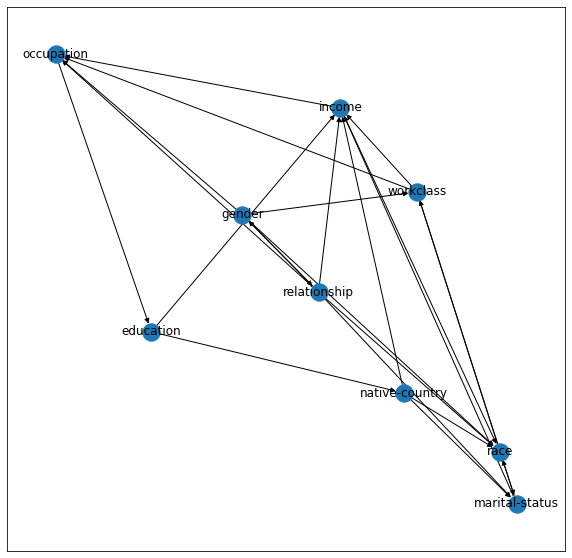

In [7]:
data_encoded_bin=pd.DataFrame(D0_bin, columns=np.array(data_encoded.columns))# Dataframe of binary dataset
# Plot causal graph for binary data
pc_gb = PC(CItest='gaussian', alpha=0.01, verbose=True).create_graph_from_data(data_encoded_bin)
plt.figure(1,figsize=(10,10)) 
#Position nodes using Fruchterman-Reingold force-directed algorithm
pos = nx.spring_layout(pc_gb)
nx.draw_networkx(pc_gb,pos,font_size=12)
plt.show()

## Locate the parents of the decision variable (Income) in the PC graph

In [8]:
# Adjacency matrix for the PC graph which reveals the links between variables
AM=np.array(nx.adjacency_matrix(pc_gb).todense())

# Find column indices for the sensitive attributes and decision variable
index_no_inc = data_encoded.columns.get_loc('income')
index_no_gen = data_encoded.columns.get_loc('gender')
index_no_rac = data_encoded.columns.get_loc('race')
index_no_nc = data_encoded.columns.get_loc('native-country')

In [9]:
# row is outwards and column is inwards of AM
#find all (outward) parents of income (decision variable) - ignoring direction of arrows in graph
out_p=np.argwhere(AM[index_no_inc,:])
#find all (inward) parents of income
in_p=np.argwhere(AM[:,index_no_inc])
all_p=np.unique(np.append(in_p,out_p))

#remove sensitive attributes
#all_p=np.delete(all_p,np.argwhere(all_p==index_no_nc))#native country
#all_p=np.delete(all_p,np.argwhere(all_p==index_no_rac))#race
all_p=np.delete(all_p,np.argwhere(all_p==index_no_gen))#gender

Q=all_p# All the parents of Income excluding sensitive attributes
np.array(data_encoded.columns [Q])

array(['education', 'workclass', 'native-country', 'occupation',
       'relationship', 'race', 'marital-status'], dtype=object)

In [10]:
D=np.copy(D0_bin[:,np.append(Q,[index_no_gen,index_no_inc])]) # Formatting the binary dataset to use as input into MData
Dq=np.unique(D[:,0:len(Q)],axis=0)
print('Number of unique tuples in set Q=',np.shape(Dq)[0])


Number of unique tuples in set Q= 96


## Implementing the algorithms presented in [Lu Zhang et al. 2016](https://arxiv.org/pdf/1611.07438.pdf)
CERTIFY provides confirmation as to whether the dataset contains discrimination.
MDATA removes discrimination from the dataset by changing the decision outcome of select individuals.

In [11]:
def Certify(D,tau,Q):
    # Certifying of Non-Discrimination in dataset D
    unqQ=np.unique(D[:,0:len(Q)],axis=0) # Unique values of set Q (parents of decision variable)
    shu=np.shape(unqQ)
    shD=np.shape(D)
    Da=D[:,0:(len(Q)+1)]
    for q in unqQ:
        #Computing P(A|B) where event A is the decision variable and event B is q and the sensitive attribute
        check1a = [np.product(indiv==np.append(q,[1])) for indiv in Da]#Male
        check1 = [np.product(indiv==np.append(q,[1,1])) for indiv in D]#Male and pos decision
        check2a = [np.product(indiv==np.append(q,[0])) for indiv in Da]#Female
        check2 = [np.product(indiv==np.append(q,[0,1])) for indiv in D]#Female and pos decision
        p1a=len(np.argwhere(check1a))/shD[0]#P(B)
        p1=len(np.argwhere(check1))/shD[0]#P(A and B)
        p2a=len(np.argwhere(check2a))/shD[0]#P(B)
        p2=len(np.argwhere(check2))/shD[0]#P(A and B)
        if p1==0:
            P1=0 #P(A|B)
        else:
            P1=(p1/p1a)#P(A|B)
        if p2==0:
            P2=0#P(A|B)
        else:
            P2=(p2/p2a)#P(A|B)    
        prob=abs(P1-P2)
        if prob>=tau:
            return 0 # Discrimination is found
    
    return 1 # No discrimination is found


In [12]:
def MData(D,tau,Q):
    #Removal of discrimination by modifying D
    unqQ=np.unique(D[:,0:len(Q)],axis=0)# Unique values of set Q (parents of decision variable)
    shu=np.shape(unqQ)
    judge=Certify(D,tau,Q)# Checking for discrimination in dataset
    shD=np.shape(D)
    Da=D[:,0:(len(Q)+1)]
    q_count=[]
    if judge==0:
        for q in unqQ:
            count=0
            #Computing P(A|B) where event A is the decision variable and event B is q and the sensitive attribute
            check1a = [np.product(indiv==np.append(q,[1])) for indiv in Da]#Male
            check1 = [np.product(indiv==np.append(q,[1,1])) for indiv in D]#Male and pos decision
            check2a = [np.product(indiv==np.append(q,[0])) for indiv in Da]#Female 
            check2 = [np.product(indiv==np.append(q,[0,1])) for indiv in D]#Female and pos decision
            p1a=len(np.argwhere(check1a))/shD[0]#P(B)
            p1=len(np.argwhere(check1))/shD[0]#P(A and B)
            p2a=len(np.argwhere(check2a))/shD[0]#P(B)
            p2=len(np.argwhere(check2))/shD[0]#P(A and B)
            if p1==0:
                P1=0#P(A|B): Male
            else:
                P1=(p1/p1a)#P(A|B): Male
            if p2==0:
                P2=0#P(A|B): Female
            else:
                P2=(p2/p2a)#P(A|B): Female  
            prob=P1-P2#Discrimination measure
            if prob>=tau:#Female discrimination
                #Repair
                nqc_neg= len(np.argwhere([np.product(indiv==np.append(q,[0])) for indiv in Da]))
                n_m=math.ceil(nqc_neg*(abs(prob)-tau))
                indm = np.argwhere([np.product(indiv==np.append(q,[0,0])) for indiv in D])
                if 0<len(indm)<=n_m:
                    indme=np.concatenate(indm)
                    D[indme,shD[1]-1]=1#Flip negative decision for underprivileged group 
                elif len(indm)>n_m: 
                    indme=np.random.choice(np.concatenate(indm), n_m, replace=False)
                    D[indme,shD[1]-1]=1#Flip negative decision for underprivileged group
 
                count=n_m
            
            elif prob<=-tau:#Male discrimination
                #Repair
                nqc_neg= len(np.argwhere([np.product(indiv==np.append(q,[0])) for indiv in Da]))
                n_m=math.ceil(nqc_neg*(abs(prob)-tau))
                indm = np.argwhere([np.product(indiv==np.append(q,[0,1])) for indiv in D])
                if 0<len(indm)<=n_m:
                    indme=np.concatenate(indm)
                    D[indme,shD[1]-1]=0#Flip positive decision for privileged group
                elif len(indm)>n_m:
                    indme=np.random.choice(np.concatenate(indm), n_m, replace=False)
                    D[indme,shD[1]-1]=0#Flip positive decision for privileged group
                
                count=-n_m
            q_count=np.append(q_count,count)
    return [D,unqQ,q_count] #Return repaired dataset, set Q, flip count for each Q
                
           

## Run the repair on the dataset using function MData

In [13]:
import time

t0 = time.time()
tau=0.01
[DR,unqQ,q_count]=MData(D,tau,Q)#Repair on dataset D
t1 = time.time()
total = t1-t0
print('Number of minutes to run the repair on the binarized dataset=',total/60)

Number of minutes to run the repair on the binarized dataset= 6.937040340900421


## Analyse the results: Compare the original dataset to the repaired dataset

In [14]:
# Compute how many outcomes were changed by the repair
D0=np.array(data_encoded)
Do=np.copy(D0[:,np.append(Q,[index_no_gen,index_no_inc])]) # Original Dataset
shDo=np.shape(Do)
Dec_col_diff=Do[:,shDo[1]-1]-DR[:,shDo[1]-1]
print(len(np.argwhere(Dec_col_diff>0)),'=Number of positive decisions flipped in sensitive group')
print(len(np.argwhere(Dec_col_diff<0)),'=Number of negative decisions flipped in sensitive group')

98 =Number of positive decisions flipped in sensitive group
347 =Number of negative decisions flipped in sensitive group


In [35]:
def DiscrimM(D,Q):
    # Function to compute the discrimation measures for dataset D
    unqQ=np.unique(D[:,0:len(Q)],axis=0)
    shu=np.shape(unqQ)
    shD=np.shape(D)
    Da=D[:,0:(len(Q)+1)]
    Probs=[]
    NoF=[]
    for q in unqQ:
        #Computing P(A|B) where event A is the decision variable and event B is q and the sensitive attribute
 
        check1a = [np.product(indiv==np.append(q,[1])) for indiv in Da]
        check1 = [np.product(indiv==np.append(q,[1,1])) for indiv in D]
        check2a = [np.product(indiv==np.append(q,[0])) for indiv in Da]
        check2 = [np.product(indiv==np.append(q,[0,1])) for indiv in D]
        p1a=len(np.argwhere(check1a))/shD[0]#P(B)
        p1=len(np.argwhere(check1))/shD[0]#P(A and B)
        p2a=len(np.argwhere(check2a))/shD[0]#P(B)
        p2=len(np.argwhere(check2))/shD[0]#P(A and B)
        if p1==0:
            P1=0 #P(A|B): Male
        else:
            P1=(p1/p1a)#P(A|B): Male
        if p2==0:
            P2=0#P(A|B): Female
        else:
            P2=(p2/p2a)#P(A|B): Female  
        Probs=np.append(Probs,P1-P2)#Discrimination measure
        NoF=np.append(NoF,len(np.argwhere(check2a)))
    return [Probs,unqQ,NoF]# Rru


In [36]:
# Compute the discrimination measures before and after the repair
D=np.copy(D0_bin[:,np.append(Q,[index_no_gen,index_no_inc])])

[P1s,unqQ,NoF]=DiscrimM(D,Q)#Discrimination measures for original dataset

In [41]:
[P2s,unqQ,NoF]=DiscrimM(DR,Q)#Discrimination measures for repaired dataset

In [50]:
# Display the change in discrimination measure for each tuple in set Q
print('For Q=',np.array(data_encoded.columns [Q]),':')
for i in range(np.shape(unqQ)[0]):
    print('Q=',unqQ[i,:],': No. of females ',NoF[i],',flipped ',q_count[i], 'decisions, P(before)=',np.round(P1s[i],decimals = 3),', P(after)=',np.round(P2s[i],decimals = 3))

For Q= ['education' 'workclass' 'native-country' 'occupation' 'relationship'
 'race' 'marital-status'] :
Q= [0 0 0 0 0 0 0] : No. of females  24.0 ,flipped  1.0 decisions, P(before)= 0.036 , P(after)= -0.006
Q= [0 0 0 0 0 0 1] : No. of females  4.0 ,flipped  1.0 decisions, P(before)= 0.25 , P(after)= 0.0
Q= [0 0 0 0 0 1 0] : No. of females  78.0 ,flipped  1.0 decisions, P(before)= 0.021 , P(after)= 0.008
Q= [0 0 0 0 0 1 1] : No. of females  4.0 ,flipped  1.0 decisions, P(before)= 0.143 , P(after)= -0.107
Q= [0 0 0 0 1 0 1] : No. of females  7.0 ,flipped  1.0 decisions, P(before)= 0.045 , P(after)= -0.098
Q= [0 0 0 0 1 1 1] : No. of females  23.0 ,flipped  2.0 decisions, P(before)= 0.06 , P(after)= -0.027
Q= [0 0 0 1 0 0 0] : No. of females  6.0 ,flipped  -1.0 decisions, P(before)= -0.167 , P(after)= 0.0
Q= [0 0 0 1 0 0 1] : No. of females  0.0 ,flipped  0.0 decisions, P(before)= 0.667 , P(after)= 0.667
Q= [0 0 0 1 0 1 0] : No. of females  3.0 ,flipped  -1.0 decisions, P(before)= -0.256

Mean discrimination before= 0.06343785771892306 , Mean discrimination after= 0.013445333696147371


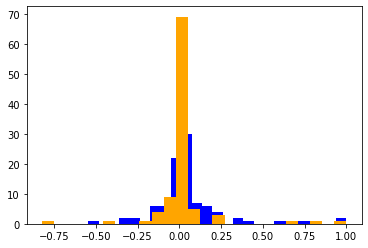

In [60]:
# Compare the distributions for discrimination measures
import matplotlib.pyplot as plt
plt.hist(P1s,bins=25,color='blue');#original dataset
plt.hist(P2s,bins=25,color='orange');#repaired dataset
print('Mean discrimination before=', np.mean(P1s),', Mean discrimination after=',np.mean(P2s))

## Compare prediction models using the original and repaired dataset

In [61]:
# Convert the modified dataset into a dataframe
Df=np.array(data_encoded)
Df[:,index_no_inc]=DR[:,np.shape(DR)[1]-1]

data_encoded_mod=pd.DataFrame(Df, columns=np.array(data_encoded.columns)) 
data_encoded_mod

,education,workclass,income,native-country,occupation,relationship,race,gender,marital-status
0,1,3,0,38,6,3,2,1,4
1,11,3,0,38,4,0,4,1,2
2,7,1,1,38,10,0,4,1,2
3,15,3,1,38,6,0,2,1,2
4,15,8,0,38,14,3,4,0,4
...,...,...,...,...,...,...,...,...,...
48837,7,3,0,38,12,5,4,0,2
48838,11,3,1,38,6,0,4,1,2
48839,11,3,0,38,0,4,4,0,6
48840,11,3,0,38,0,3,4,1,4


In [63]:
# train a XGBoost model to predict 'income'

standard_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=4)    
standard_model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=4, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [66]:
# Predict with the modified dataset
# split train/validate/test

data_remaining, test = train_test_split(data_encoded, test_size=0.1)
train, valid = train_test_split(data_remaining, test_size=0.1112)
# because we don't want to train on protected attributes or labels to be predicted, 
# let's remove these columns from the training dataset

protected_train = train['gender'].copy() # gender is a protected attribute
y_train = train['income'].copy() # labels we're going to train the model to predict
x_train = train.drop(columns=['gender','income'])
protected_valid = valid['gender'].copy() 
y_valid = valid['income'].copy() 
x_valid = valid.drop(columns=['gender','income'])
protected_test = test['gender'].copy() 
y_test = test['income'].copy()
x_test = test.drop(columns=['gender','income'])
# because we don't want to train on protected attributes or labels to be predicted, 
# let's remove these columns from the training dataset

protected_train = train['gender'].copy() # gender is a protected attribute
y_train = train['income'].copy() # labels we're going to train the model to predict
x_train = train.drop(columns=['gender','income'])
protected_valid = valid['gender'].copy() 
y_valid = valid['income'].copy() 
x_valid = valid.drop(columns=['gender','income'])
protected_test = test['gender'].copy() 
y_test = test['income'].copy()
x_test = test.drop(columns=['gender','income'])
y_train_pred = standard_model.predict(x_train)
y_valid_pred = standard_model.predict(x_valid)
print('Model accuracy on the training dataset before repair:', 
      round(100 * accuracy_score(y_train, y_train_pred),2),'%') # round the score to 2 digits  

print('Model accuracy on the validation dataset before repair:', 
      round(100 * accuracy_score(y_valid, y_valid_pred),2),'%')
# Small reduction in accuracy

Model accuracy on the training dataset before repair: 84.36 %
Model accuracy on the validation dataset before repair: 83.29 %


In [67]:
# Predict with the modified dataset
# split train/validate/test

data_remaining, test = train_test_split(data_encoded_mod, test_size=0.1)
train, valid = train_test_split(data_remaining, test_size=0.1112)
# because we don't want to train on protected attributes or labels to be predicted, 
# let's remove these columns from the training dataset

protected_train = train['gender'].copy() # gender is a protected attribute
y_train = train['income'].copy() # labels we're going to train the model to predict
x_train = train.drop(columns=['gender','income'])
protected_valid = valid['gender'].copy() 
y_valid = valid['income'].copy() 
x_valid = valid.drop(columns=['gender','income'])
protected_test = test['gender'].copy() 
y_test = test['income'].copy()
x_test = test.drop(columns=['gender','income'])
# because we don't want to train on protected attributes or labels to be predicted, 
# let's remove these columns from the training dataset

protected_train = train['gender'].copy() # gender is a protected attribute
y_train = train['income'].copy() # labels we're going to train the model to predict
x_train = train.drop(columns=['gender','income'])
protected_valid = valid['gender'].copy() 
y_valid = valid['income'].copy() 
x_valid = valid.drop(columns=['gender','income'])
protected_test = test['gender'].copy() 
y_test = test['income'].copy()
x_test = test.drop(columns=['gender','income'])
y_train_pred = standard_model.predict(x_train)
y_valid_pred = standard_model.predict(x_valid)
print('Model accuracy on the training dataset after repair:', 
      round(100 * accuracy_score(y_train, y_train_pred),2),'%') # round the score to 2 digits  

print('Model accuracy on the validation dataset after repair:', 
      round(100 * accuracy_score(y_valid, y_valid_pred),2),'%')
# Small reduction in accuracy

Model accuracy on the training dataset after repair: 83.77 %
Model accuracy on the validation dataset after repair: 82.74 %


## Focus on Gender and Education
Instead study the sensitive attribute + one other attribute to obtain larger groups, which could result in more changes to the decision variable.

In [83]:
index_no_edu = data_encoded.columns.get_loc('education')
Qn=index_no_edu

In [84]:
D=np.copy(D0_bin[:,np.append(Qn,[index_no_gen,index_no_inc])])# Dataset for education, gender,income
Dq=np.unique(D[:,1],axis=0)
print('Number of unique tuples in set Qn=',np.shape(Dq)[0])

Number of unique tuples in set Qn= 2


In [85]:
[DRn,unqQn,qn_count]=MData(D,tau,[Qn])# Perform the repair


In [86]:
# Compute the discrimination measures before and after the repair
D=np.copy(D0_bin[:,np.append(Qn,[index_no_gen,index_no_inc])])

[P1ns,unqQn,NoFn]=DiscrimM(D,[Qn])#Discrimination measures for original dataset
[P2ns,unqQn,NoFn]=DiscrimM(DRn,[Qn])#Discrimination measures for repaired dataset

In [88]:
# The change in discrimination measure for each tuple in set Q
print('For Qn=',np.array(data_encoded.columns [Qn]),':')
for i in range(np.shape(unqQn)[0]):
    print('Qn=',unqQn[i,:],': No. of females ',NoFn[i],', flipped ',qn_count[i], 'decisions, P(before)=',np.round(P1ns[i],decimals = 3),', P(after)=',np.round(P2ns[i],decimals = 3))

For Qn= education :
Qn= [0] : No. of females  12625.0 , flipped  1681.0 decisions, P(before)= 0.143 , P(after)= 0.01
Qn= [1] : No. of females  3567.0 , flipped  1065.0 decisions, P(before)= 0.308 , P(after)= 0.01


### Comparing prediction models

In [89]:
# Convert the modified dataset into a dataframe
Df=np.array(data_encoded)
Df[:,index_no_inc]=DRn[:,np.shape(DRn)[1]-1]

data_encoded_mod=pd.DataFrame(Df, columns=np.array(data_encoded.columns)) 
data_encoded_mod

,education,workclass,income,native-country,occupation,relationship,race,gender,marital-status
0,1,3,0,38,6,3,2,1,4
1,11,3,0,38,4,0,4,1,2
2,7,1,1,38,10,0,4,1,2
3,15,3,1,38,6,0,2,1,2
4,15,8,0,38,14,3,4,0,4
...,...,...,...,...,...,...,...,...,...
48837,7,3,0,38,12,5,4,0,2
48838,11,3,1,38,6,0,4,1,2
48839,11,3,0,38,0,4,4,0,6
48840,11,3,0,38,0,3,4,1,4


In [90]:
# Predict with the modified dataset
# split train/validate/test

data_remaining, test = train_test_split(data_encoded_mod, test_size=0.1)
train, valid = train_test_split(data_remaining, test_size=0.1112)
# because we don't want to train on protected attributes or labels to be predicted, 
# let's remove these columns from the training dataset

protected_train = train['gender'].copy() # gender is a protected attribute
y_train = train['income'].copy() # labels we're going to train the model to predict
x_train = train.drop(columns=['gender','income'])
protected_valid = valid['gender'].copy() 
y_valid = valid['income'].copy() 
x_valid = valid.drop(columns=['gender','income'])
protected_test = test['gender'].copy() 
y_test = test['income'].copy()
x_test = test.drop(columns=['gender','income'])
# because we don't want to train on protected attributes or labels to be predicted, 
# let's remove these columns from the training dataset

protected_train = train['gender'].copy() # gender is a protected attribute
y_train = train['income'].copy() # labels we're going to train the model to predict
x_train = train.drop(columns=['gender','income'])
protected_valid = valid['gender'].copy() 
y_valid = valid['income'].copy() 
x_valid = valid.drop(columns=['gender','income'])
protected_test = test['gender'].copy() 
y_test = test['income'].copy()
x_test = test.drop(columns=['gender','income'])
y_train_pred = standard_model.predict(x_train)
y_valid_pred = standard_model.predict(x_valid)
print('Model accuracy on the training dataset after repair:', 
      round(100 * accuracy_score(y_train, y_train_pred),2),'%') # round the score to 2 digits  

print('Model accuracy on the validation dataset after repair:', 
      round(100 * accuracy_score(y_valid, y_valid_pred),2),'%')
# Small reduction in accuracy

Model accuracy on the training dataset after repair: 78.85 %
Model accuracy on the validation dataset after repair: 79.96 %
